# Getting Started with Qiskit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ionq-samples/getting-started/blob/main/qiskit.ipynb)

[Qiskit](https://qiskit.org/) is an open-source quantum computing framework developed by IBM for building, simulating, and running quantum circuits on real and simulated quantum devices.

In [1]:
%%capture

# First, we install the essential libraries to our current Python runtime.
# "%%capture" (above) captures and in this case, hides the output of this
# cell, so you can comment it out if you need help debugging this step.

%pip install qiskit qiskit_ionq matplotlib pylatexenc

In [2]:
import os, qiskit_ionq
from getpass import getpass

# Before you begin, get your API key from https://cloud.ionq.com/settings/keys

# If your API key is stored as "IONQ_API_KEY" in your local environment, this
# should find it. Otherwise you'll be prompted to enter your API key manually.

api_key = os.getenv('IONQ_API_KEY') or getpass('Enter your IonQ API key: ')
provider = qiskit_ionq.IonQProvider(api_key)

# We need to specify a backend, which is where the circuit will be executed. In
# this case we're using the `ionq_simulator`, but if you have QPU access you
# can specify it here to run the job on a QPU directly.

backend = provider.get_backend('ionq_simulator')

Enter your IonQ API key: 


In [4]:
from qiskit import QuantumCircuit

# Now we set up our circuit. In this case, we're creating a circuit with two
# qubits, applying an H gate to qubit-0, a CXGate to both, then measuring.

import numpy as np


# Number to be factorized
N = 15

# Choose a random number a such that 1 < a < N
a = 7

# Number of qubits for the control register
n = 4

# Create a quantum circuit with n qubits for the control register and n qubits for the work register
qc = QuantumCircuit(2*n, n)

# Apply Hadamard gates to the control register
for i in range(n):
    qc.h(i)

# Apply the modular exponentiation operation
def c_amod15(qc, a, power, ctl, tgt):
    if a == 2:
        qc.cswap(ctl, tgt, tgt+1)
        qc.cswap(ctl, tgt+1, tgt+2)
        qc.cswap(ctl, tgt+2, tgt+3)
    elif a == 7:
        qc.cx(ctl, tgt)
        qc.cx(ctl, tgt+2)
        qc.cx(ctl, tgt+3)
        qc.ccx(ctl, tgt, tgt+1)
        qc.ccx(ctl, tgt+1, tgt+2)
        qc.ccx(ctl, tgt+2, tgt+3)
    elif a == 11:
        qc.cx(ctl, tgt)
        qc.cx(ctl, tgt+1)
        qc.cx(ctl, tgt+3)
        qc.ccx(ctl, tgt, tgt+2)
        qc.ccx(ctl, tgt+1, tgt+3)
        qc.ccx(ctl, tgt+2, tgt+3)
    elif a == 13:
        qc.cx(ctl, tgt)
        qc.cx(ctl, tgt+1)
        qc.cx(ctl, tgt+2)
        qc.ccx(ctl, tgt, tgt+3)
        qc.ccx(ctl, tgt+1, tgt+2)
        qc.ccx(ctl, tgt+2, tgt+3)

    return qc

for i in range(n):
    qc.x(n+i)
    c_amod15(qc, a, 2**i, i, n)
    qc.x(n+i)

# Apply the Quantum Fourier Transform (QFT)
def qft(qc, n):
    for i in range(n):
        qc.h(i)
        for j in range(i+1, n):
            qc.cp(np.pi/2**(j-i), j, i)
    for i in range(n//2):
        qc.swap(i, n-i-1)

qft(qc, n)

# Measure the control register
qc.measure(range(n), range(n))



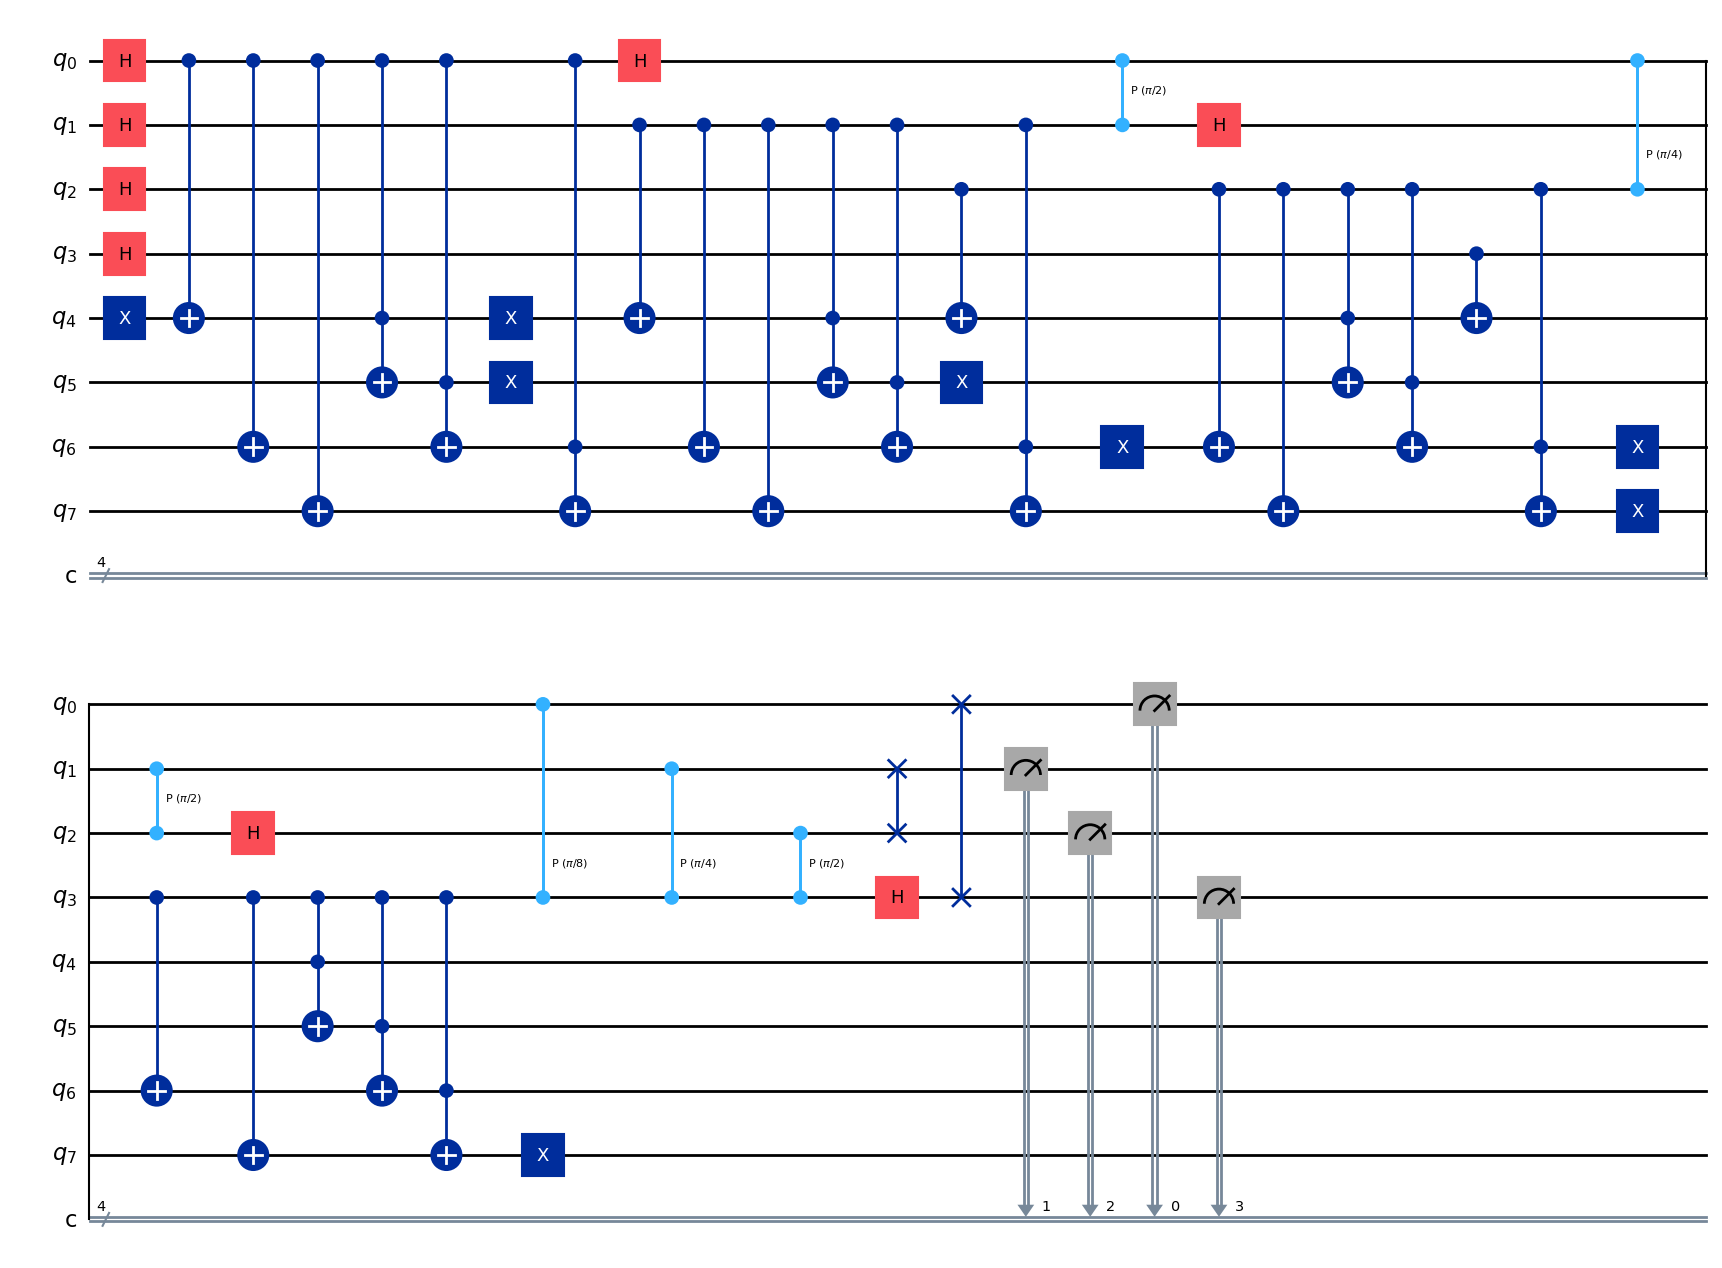

In [5]:
# Before submitting the job, we can visualize the circuit using draw().
# We're using matplotlib to create a pretty graphic, but draw() defaults to
# plaintext and supports other libraries like LaTeX.

qc.draw('mpl')

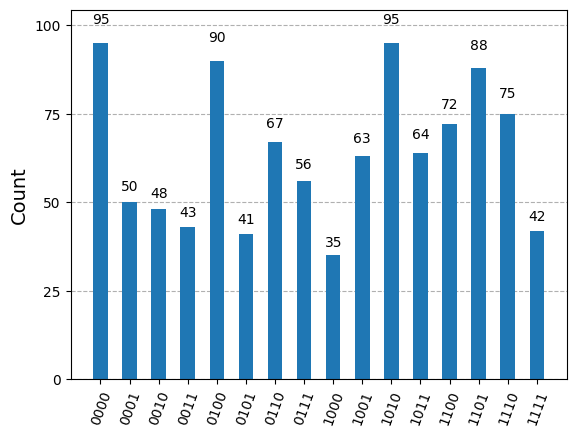

In [6]:
from qiskit.visualization import plot_histogram

# Now we'll send the job to our backend for processing.

job = backend.run(qc)

# And once the job has run, we can plot the results.

plot_histogram(job.result().get_counts())

## And that's a wrap!

To continue learning with Qiskit, check out more advanced examples here: https://github.com/ionq-samples/qiskit-getting-started

In [7]:
counts = job.result().get_counts()
decimal_counts = {int(key, 2): value for key, value in counts.items()}
print(decimal_counts)

{0: np.int64(93), 1: np.int64(60), 4: np.int64(80), 5: np.int64(52), 6: np.int64(47), 7: np.int64(76), 8: np.int64(28), 9: np.int64(78), 10: np.int64(99), 11: np.int64(61), 12: np.int64(69), 13: np.int64(82), 14: np.int64(68), 15: np.int64(34), 2: np.int64(47), 3: np.int64(50)}


In [11]:
decimal_counts = {int(key, 2): value for key, value in counts.items()}

# Sort the decimal counts in descending order of their counts
sorted_decimal_counts = sorted(decimal_counts.items(), key=lambda x: x[1], reverse=True)

print("Most Likely Measurement Outcomes:")
for outcome, count in sorted_decimal_counts:
    print(f"Outcome: {outcome}, Count: {count}")

Most Likely Measurement Outcomes:
Outcome: 10, Count: 99
Outcome: 0, Count: 93
Outcome: 13, Count: 82
Outcome: 4, Count: 80
Outcome: 9, Count: 78
Outcome: 7, Count: 76
Outcome: 12, Count: 69
Outcome: 14, Count: 68
Outcome: 11, Count: 61
Outcome: 1, Count: 60
Outcome: 5, Count: 52
Outcome: 3, Count: 50
Outcome: 6, Count: 47
Outcome: 2, Count: 47
Outcome: 15, Count: 34
Outcome: 8, Count: 28


In [9]:
from fractions import Fraction

N = 15  # Number to be factored
a = 7   # Random number between 1 and N

for outcome, count in sorted_decimal_counts:
    if outcome != 0:  # Skip outcome 0
        r = Fraction(outcome, 2**4).limit_denominator(N).denominator
        print(f"Outcome: {outcome}, Period: {r}")

Outcome: 10, Period: 8
Outcome: 13, Period: 11
Outcome: 4, Period: 4
Outcome: 9, Period: 9
Outcome: 7, Period: 9
Outcome: 12, Period: 4
Outcome: 14, Period: 8
Outcome: 11, Period: 13
Outcome: 1, Period: 15
Outcome: 5, Period: 13
Outcome: 3, Period: 11
Outcome: 6, Period: 8
Outcome: 2, Period: 8
Outcome: 15, Period: 15
Outcome: 8, Period: 2


In [12]:
from fractions import Fraction
import math

def gcd(a, b):
    while b != 0:
        a, b = b, a % b
    return a

N = 15  # Number to be factored
a = 7   # Random number between 1 and N

for outcome, count in sorted_decimal_counts:
    if outcome != 0:  # Skip outcome 0
        r = Fraction(outcome, 2**4).limit_denominator(N).denominator
        print(f"Outcome: {outcome}, Period: {r}")
        if r % 2 == 0:
            x = pow(a, r//2, N)
            if x != 1 and x != N - 1:
                factor1 = gcd(x + 1, N)
                factor2 = gcd(x - 1, N)
                print(f"Outcome: {outcome}, Period: {r}, Factors: {factor1}, {factor2}")
            else:
                print(f"Outcome: {outcome}, Period: {r}, Invalid outcome: x = {x}")
        else:
            print(f"Outcome: {outcome}, Period: {r}, Invalid outcome: r is odd")

Outcome: 10, Period: 8
Outcome: 10, Period: 8, Invalid outcome: x = 1
Outcome: 13, Period: 11
Outcome: 13, Period: 11, Invalid outcome: r is odd
Outcome: 4, Period: 4
Outcome: 4, Period: 4, Factors: 5, 3
Outcome: 9, Period: 9
Outcome: 9, Period: 9, Invalid outcome: r is odd
Outcome: 7, Period: 9
Outcome: 7, Period: 9, Invalid outcome: r is odd
Outcome: 12, Period: 4
Outcome: 12, Period: 4, Factors: 5, 3
Outcome: 14, Period: 8
Outcome: 14, Period: 8, Invalid outcome: x = 1
Outcome: 11, Period: 13
Outcome: 11, Period: 13, Invalid outcome: r is odd
Outcome: 1, Period: 15
Outcome: 1, Period: 15, Invalid outcome: r is odd
Outcome: 5, Period: 13
Outcome: 5, Period: 13, Invalid outcome: r is odd
Outcome: 3, Period: 11
Outcome: 3, Period: 11, Invalid outcome: r is odd
Outcome: 6, Period: 8
Outcome: 6, Period: 8, Invalid outcome: x = 1
Outcome: 2, Period: 8
Outcome: 2, Period: 8, Invalid outcome: x = 1
Outcome: 15, Period: 15
Outcome: 15, Period: 15, Invalid outcome: r is odd
Outcome: 8, Period